In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.001

dv = 0.001

klin =0

nband = 200

ng =11

ng_adju = (/ -3 , -3 /) 

ng_refs = (/ 2 , 3 , 6 /) 

nref =3

nv = 1000

nv = 1000

option_compute_btable = 1

option_compute_ktable =0

option_klin =0

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 10 , 500 /) 

t_refs = (/ 250 , 250 , 250 /) 

tsfc =257

vstar = 340

data w_diffuse
     &     /1.66 , 1.66 , 1.8 , 1.8,
     &     1.8 , 1.8 , 1.8 , 1.66,
     &     1.45 , 1.45 , 1.45/

data wgt
     &     /0.6 , 0.6 , 0.6 , 0.6,
     &     0.6 , 0.6 , 0.6 , 0.6,
     &     0.6 , 0.6 , 0.6/

atmosphere_profiles/saw75.pro


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

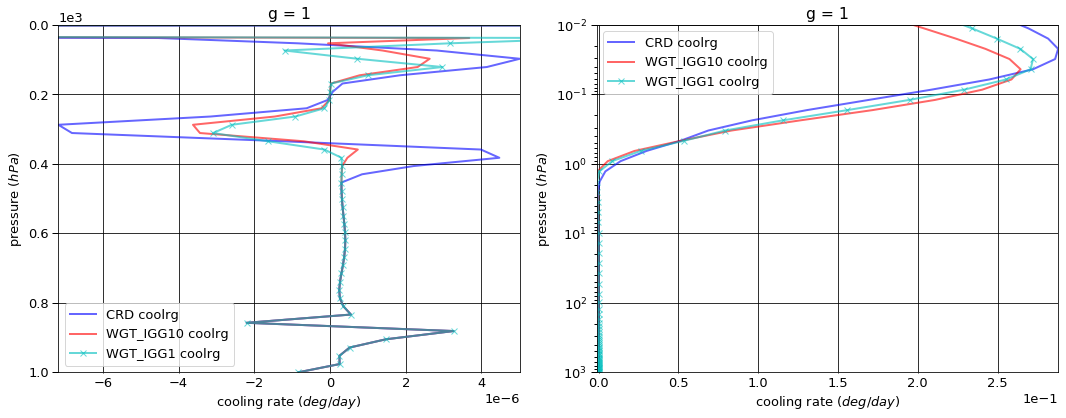

# Figure: cooling rate g-group 2

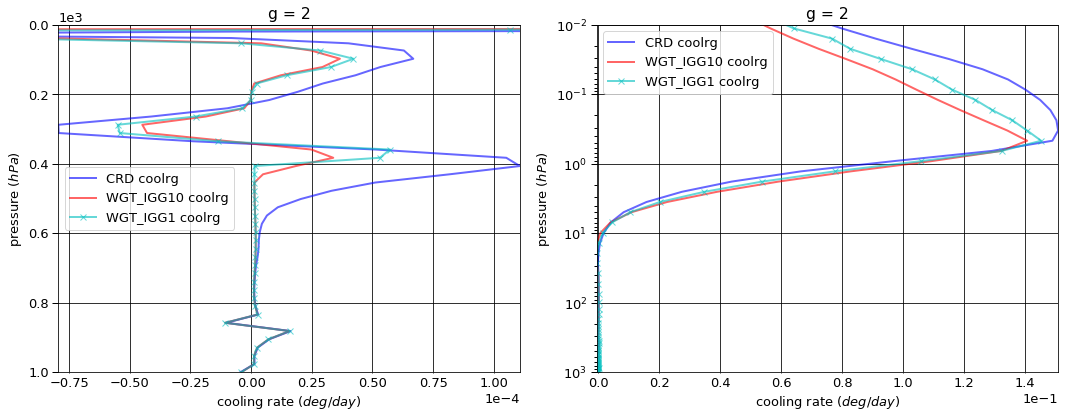

# Figure: cooling rate g-group 3

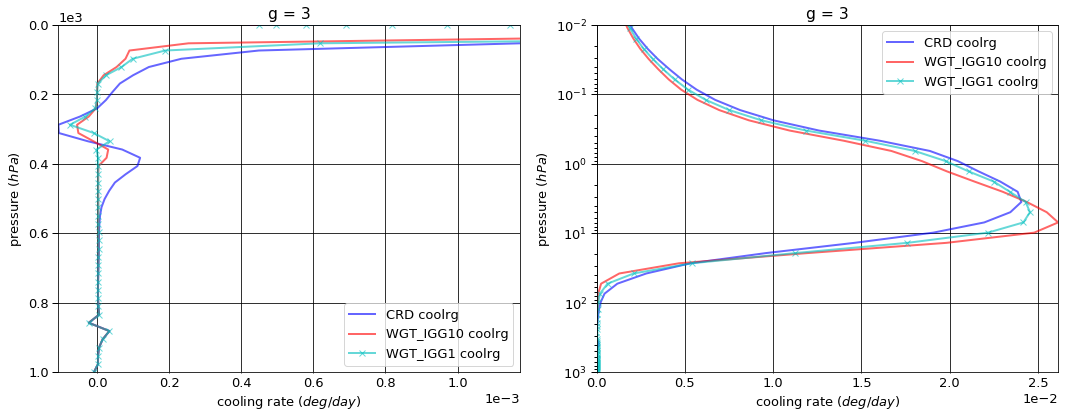

# Figure: cooling rate g-group 4

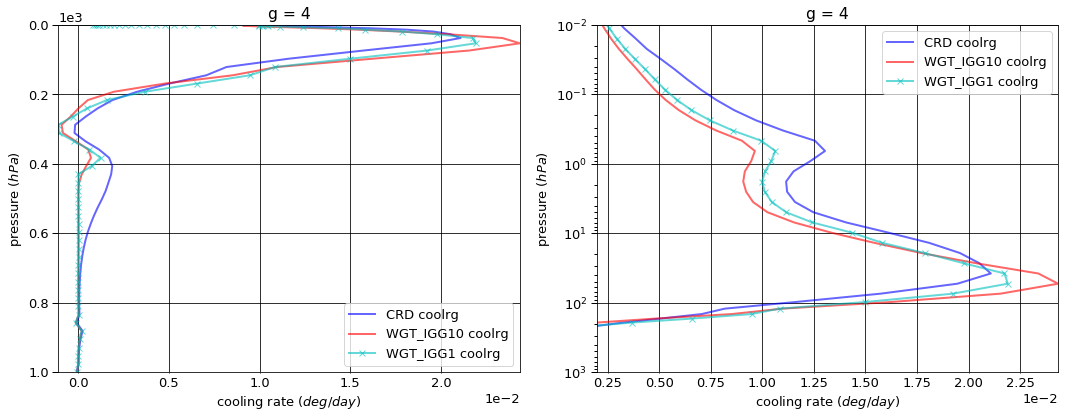

# Figure: cooling rate g-group 5

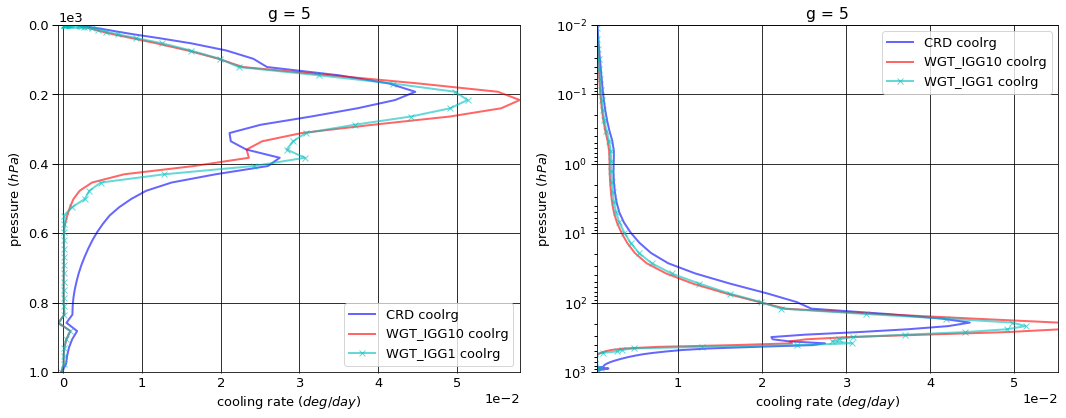

# Figure: cooling rate g-group 6

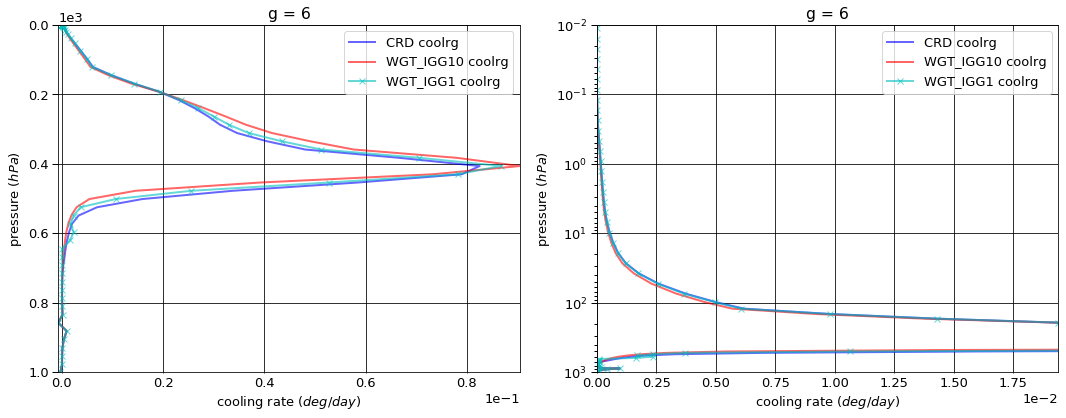

# Figure: cooling rate g-group 7

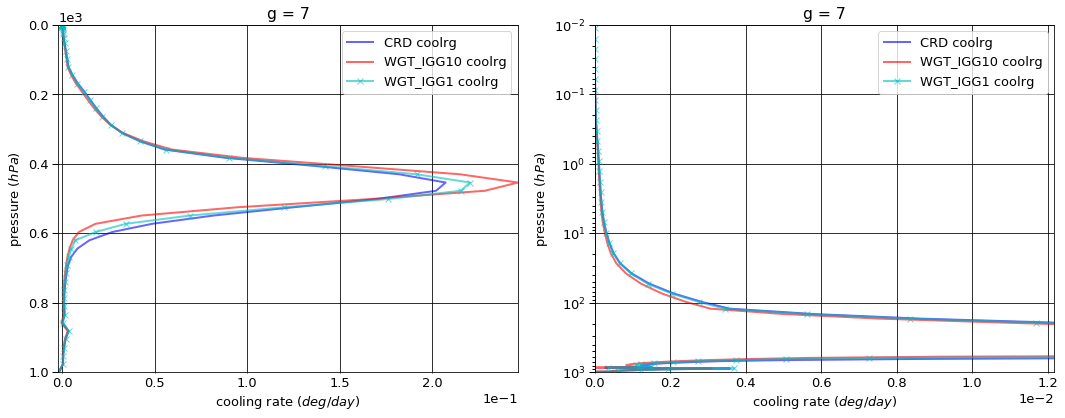

# Figure: cooling rate g-group 8

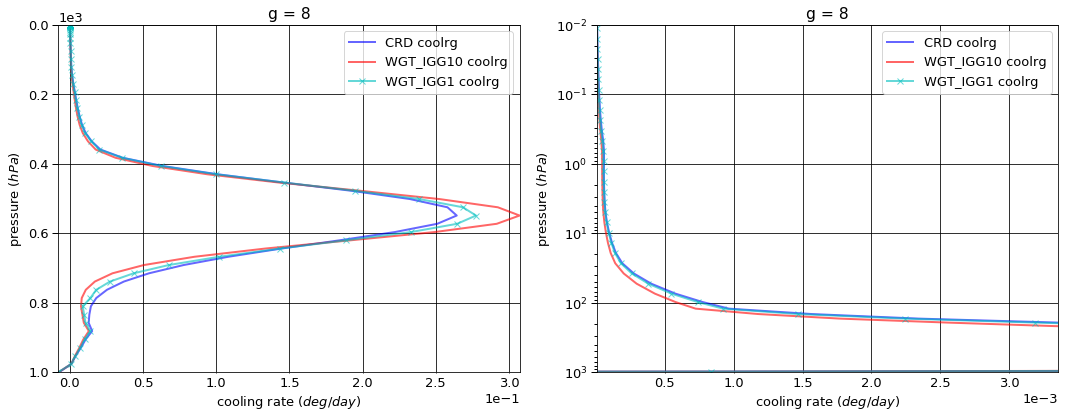

# Figure: cooling rate g-group 9

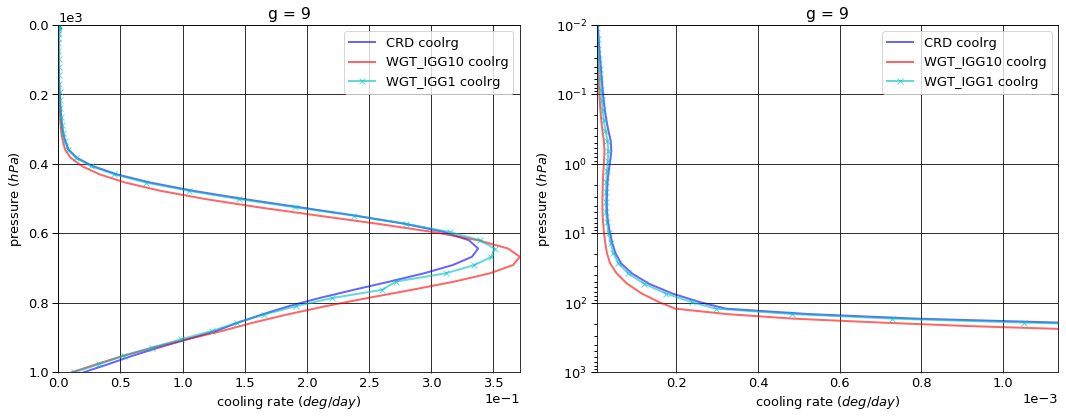

# Figure: cooling rate g-group 10

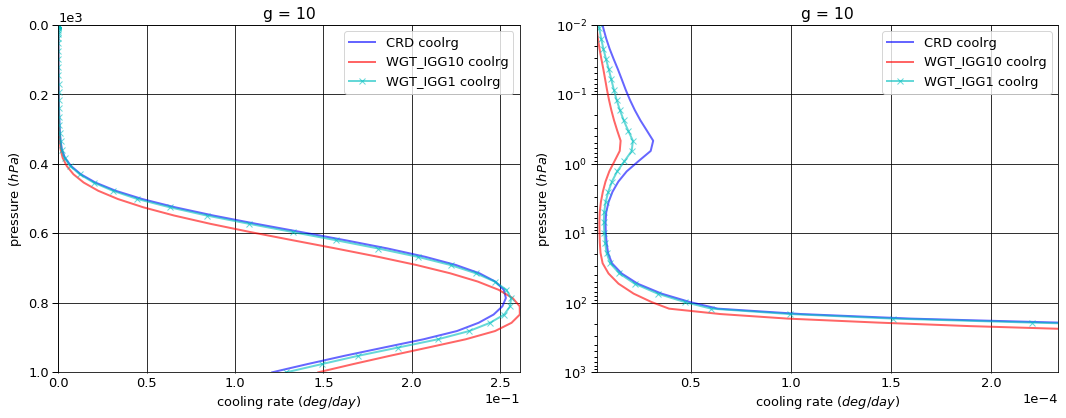

# Figure: cooling rate g-group 11

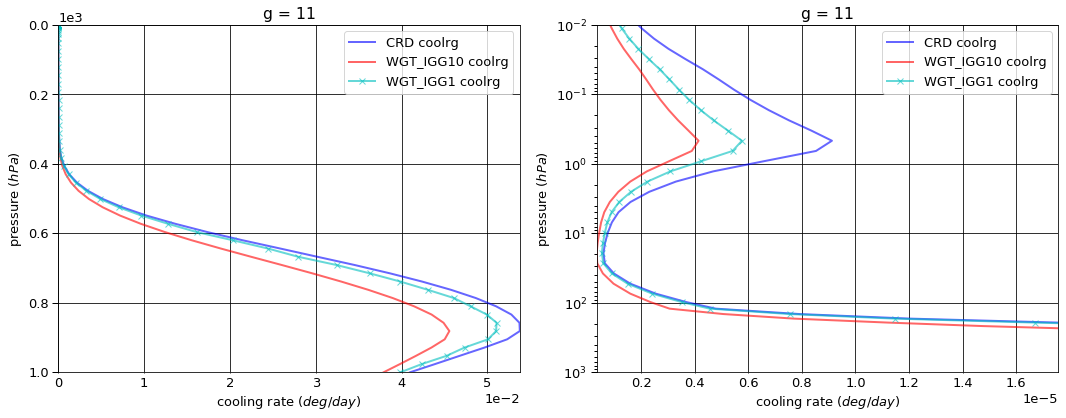

# Figure: cooling rate g-group total

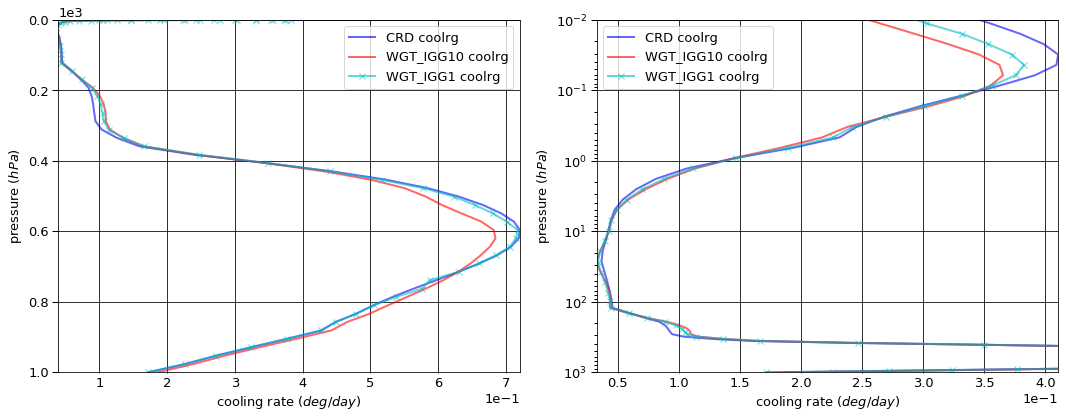

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.008438   0.000000  -0.008438
   1013.0   76     -0.009107   0.009110   0.000003
2  0.0      1      -0.032734   0.000000  -0.032734
   1013.0   76     -0.040746   0.040761   0.000015
3  0.0      1      -0.060027   0.000000  -0.060027
   1013.0   76     -0.092264   0.092295   0.000031
4  0.0      1      -0.335874   0.000000  -0.335874
   1013.0   76     -0.526609   0.526952   0.000344
5  0.0      1      -1.618736   0.000000  -1.618736
   1013.0   76     -2.422557   2.419542  -0.003015
6  0.0      1      -1.828634   0.000000  -1.828634
   1013.0   76     -2.619665   2.620543   0.000878
7  0.0      1      -4.405622   0.000000  -4.405622
   1013.0   76     -5.760466   5.767100   0.006634
8  0.0      1      -7.195748   0.000000  -7.195748
   1013.0   76     -8.529641   8.569900   0.040259
9  0.0      1     -13.589676   0.000000 -13.589676
   1013.0   76    -14.790005  14.510595  -0.279410
10 0.0      1     -16.015192   0.000000 -16.015192
   1013.0   76    -16.507235  11.989725  -4.517510
11 0.0      1      -6.824047   0.000000  -6.824047
   1013.0   76     -6.885235   2.300267  -4.584968


WGT_IGG10


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.008519   0.000000  -0.008519
   1013.0   76     -0.009107   0.009110   0.000003
2  0.0      1      -0.033266   0.000000  -0.033266
   1013.0   76     -0.040746   0.040760   0.000014
3  0.0      1      -0.059942   0.000000  -0.059942
   1013.0   76     -0.092264   0.092294   0.000030
4  0.0      1      -0.327287   0.000000  -0.327287
   1013.0   76     -0.526609   0.526782   0.000173
5  0.0      1      -1.551299   0.000000  -1.551299
   1013.0   76     -2.422557   2.423355   0.000798
6  0.0      1      -1.801005   0.000000  -1.801005
   1013.0   76     -2.619665   2.620523   0.000858
7  0.0      1      -4.356856   0.000000  -4.356856
   1013.0   76     -5.760466   5.765449   0.004983
8  0.0      1      -7.172964   0.000000  -7.172964
   1013.0   76     -8.529641   8.565166   0.035525
9  0.0      1     -13.697117   0.000000 -13.697117
   1013.0   76    -14.790005  14.784481  -0.005524
10 0.0      1     -16.132503   0.000000 -16.132503
   1013.0   76    -16.507235  11.653168  -4.854068
11 0.0      1      -6.843297   0.000000  -6.843297
   1013.0   76     -6.885235   1.866264  -5.018971


WGT_IGG1


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.008497   0.000000  -0.008497
   1013.0   76     -0.009107   0.009110   0.000003
2  0.0      1      -0.033137   0.000000  -0.033137
   1013.0   76     -0.040746   0.040760   0.000014
3  0.0      1      -0.059917   0.000000  -0.059917
   1013.0   76     -0.092264   0.092294   0.000030
4  0.0      1      -0.327905   0.000000  -0.327905
   1013.0   76     -0.526609   0.526782   0.000173
5  0.0      1      -1.561523   0.000000  -1.561523
   1013.0   76     -2.422557   2.423355   0.000798
6  0.0      1      -1.816743   0.000000  -1.816743
   1013.0   76     -2.619665   2.620523   0.000858
7  0.0      1      -4.385214   0.000000  -4.385214
   1013.0   76     -5.760466   5.767340   0.006874
8  0.0      1      -7.177220   0.000000  -7.177220
   1013.0   76     -8.529641   8.568710   0.039069
9  0.0      1     -13.581230   0.000000 -13.581230
   1013.0   76    -14.790005  14.707100  -0.082905
10 0.0      1     -16.031903   0.000000 -16.031903
   1013.0   76    -16.507235  12.044782  -4.462454
11 0.0      1      -6.827441   0.000000  -6.827441
   1013.0   76     -6.885235   2.181407  -4.703828


WGT_IGG10 - CRD


flug      fldg     fnetg
g  pressure level                                  
1  0.0      1     -8.100490e-05  0.000000 -0.000081
   1013.0   76     0.000000e+00  0.000000  0.000000
2  0.0      1     -5.321820e-04  0.000000 -0.000532
   1013.0   76     0.000000e+00 -0.000002 -0.000002
3  0.0      1      8.455600e-05  0.000000  0.000085
   1013.0   76     0.000000e+00 -0.000001 -0.000001
4  0.0      1      8.587260e-03  0.000000  0.008587
   1013.0   76     0.000000e+00 -0.000171 -0.000171
5  0.0      1      6.743720e-02  0.000000  0.067437
   1013.0   76    -4.440892e-16  0.003813  0.003813
6  0.0      1      2.762940e-02  0.000000  0.027629
   1013.0   76     0.000000e+00 -0.000020 -0.000020
7  0.0      1      4.876670e-02  0.000000  0.048767
   1013.0   76     0.000000e+00 -0.001651 -0.001651
8  0.0      1      2.278310e-02  0.000000  0.022783
   1013.0   76     0.000000e+00 -0.004734 -0.004734
9  0.0      1     -1.074410e-01  0.000000 -0.107441
   1013.0   76    -1.776357e-15  0.273886  0.273885
10 0.0      1     -1.173110e-01  0.000000 -0.117311
   1013.0   76     0.000000e+00 -0.336557 -0.336557
11 0.0      1     -1.924930e-02  0.000000 -0.019249
   1013.0   76     0.000000e+00 -0.434003 -0.434003


WGT_IGG1 - CRD


flug      fldg     fnetg
g  pressure level                                  
1  0.0      1     -5.923850e-05  0.000000 -0.000059
   1013.0   76     0.000000e+00  0.000000  0.000000
2  0.0      1     -4.033010e-04  0.000000 -0.000403
   1013.0   76     0.000000e+00 -0.000002 -0.000002
3  0.0      1      1.097840e-04  0.000000  0.000110
   1013.0   76     0.000000e+00 -0.000001 -0.000001
4  0.0      1      7.969540e-03  0.000000  0.007970
   1013.0   76     0.000000e+00 -0.000171 -0.000171
5  0.0      1      5.721370e-02  0.000000  0.057214
   1013.0   76    -4.440892e-16  0.003813  0.003813
6  0.0      1      1.189170e-02  0.000000  0.011892
   1013.0   76     0.000000e+00 -0.000020 -0.000020
7  0.0      1      2.040840e-02  0.000000  0.020408
   1013.0   76     0.000000e+00  0.000240  0.000240
8  0.0      1      1.852720e-02  0.000000  0.018527
   1013.0   76     0.000000e+00 -0.001190 -0.001190
9  0.0      1      8.446000e-03  0.000000  0.008446
   1013.0   76    -1.776357e-15  0.196505  0.196505
10 0.0      1     -1.671100e-02  0.000000 -0.016711
   1013.0   76     0.000000e+00  0.055057  0.055057
11 0.0      1     -3.394000e-03  0.000000 -0.003394
   1013.0   76     0.000000e+00 -0.118860 -0.118860

# Table: cooling rate. g-groups 


CRD


coolrg
g  pressure    layer              
1  0.000312    1      1.061730e-01
   1001.112500 75    -8.325662e-07
2  0.000312    1      1.911718e-02
   1001.112500 75    -4.467355e-06
3  0.000312    1      4.210688e-04
   1001.112500 75    -9.080559e-06
4  0.000312    1      9.891199e-04
   1001.112500 75    -8.133701e-05
5  0.000312    1      1.180092e-04
   1001.112500 75    -1.948751e-04
6  0.000312    1      4.017027e-07
   1001.112500 75    -2.540379e-04
7  0.000312    1      6.640148e-07
   1001.112500 75    -1.836125e-03
8  0.000312    1      1.590744e-06
   1001.112500 75    -7.503479e-03
9  0.000312    1      1.510001e-06
   1001.112500 75     2.040133e-02
10 0.000312    1      8.057950e-07
   1001.112500 75     1.210456e-01
11 0.000312    1      1.165631e-07
   1001.112500 75     4.099371e-02


WGT_IGG10


coolrg
g  pressure    layer              
1  0.000312    1      6.118578e-02
   1001.112500 75    -8.325662e-07
2  0.000312    1      1.605850e-02
   1001.112500 75    -4.040170e-06
3  0.000312    1      4.258504e-04
   1001.112500 75    -8.693221e-06
4  0.000312    1      7.656429e-04
   1001.112500 75    -5.032093e-05
5  0.000312    1      1.190357e-04
   1001.112500 75    -2.319611e-04
6  0.000312    1      3.626222e-07
   1001.112500 75    -2.494435e-04
7  0.000312    1      5.693545e-07
   1001.112500 75    -1.425880e-03
8  0.000312    1      1.132033e-06
   1001.112500 75    -7.790105e-03
9  0.000312    1      7.348268e-07
   1001.112500 75     1.093563e-02
10 0.000312    1      3.373810e-07
   1001.112500 75     1.471059e-01
11 0.000312    1      4.878912e-08
   1001.112500 75     3.791079e-02


WGT_IGG1


coolrg
g  pressure    layer              
1  0.000312    1      8.061088e-02
   1001.112500 75    -8.325662e-07
2  0.000312    1      1.739732e-02
   1001.112500 75    -4.040170e-06
3  0.000312    1      4.479918e-04
   1001.112500 75    -8.693221e-06
4  0.000312    1      8.426047e-04
   1001.112500 75    -5.032093e-05
5  0.000312    1      1.321139e-04
   1001.112500 75    -2.319611e-04
6  0.000312    1      4.088956e-07
   1001.112500 75    -2.494435e-04
7  0.000312    1      6.571941e-07
   1001.112500 75    -1.961838e-03
8  0.000312    1      1.475454e-06
   1001.112500 75    -7.895177e-03
9  0.000312    1      1.152855e-06
   1001.112500 75     1.277857e-02
10 0.000312    1      5.631343e-07
   1001.112500 75     1.290592e-01
11 0.000312    1      8.410509e-08
   1001.112500 75     3.987819e-02


WGT_IGG10 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -4.498726e-02
   1001.112500 75     0.000000e+00
2  0.000312    1     -3.058679e-03
   1001.112500 75     4.271849e-07
3  0.000312    1      4.781630e-06
   1001.112500 75     3.873381e-07
4  0.000312    1     -2.234770e-04
   1001.112500 75     3.101608e-05
5  0.000312    1      1.026520e-06
   1001.112500 75    -3.708602e-05
6  0.000312    1     -3.908053e-08
   1001.112500 75     4.594470e-06
7  0.000312    1     -9.466026e-08
   1001.112500 75     4.102457e-04
8  0.000312    1     -4.587114e-07
   1001.112500 75    -2.866262e-04
9  0.000312    1     -7.751743e-07
   1001.112500 75    -9.465702e-03
10 0.000312    1     -4.684140e-07
   1001.112500 75     2.606025e-02
11 0.000312    1     -6.777401e-08
   1001.112500 75    -3.082916e-03


WGT_IGG1 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -2.556216e-02
   1001.112500 75     0.000000e+00
2  0.000312    1     -1.719857e-03
   1001.112500 75     4.271849e-07
3  0.000312    1      2.692301e-05
   1001.112500 75     3.873381e-07
4  0.000312    1     -1.465151e-04
   1001.112500 75     3.101608e-05
5  0.000312    1      1.410473e-05
   1001.112500 75    -3.708602e-05
6  0.000312    1      7.192890e-09
   1001.112500 75     4.594470e-06
7  0.000312    1     -6.820630e-09
   1001.112500 75    -1.257125e-04
8  0.000312    1     -1.152903e-07
   1001.112500 75    -3.916980e-04
9  0.000312    1     -3.571465e-07
   1001.112500 75    -7.622759e-03
10 0.000312    1     -2.426607e-07
   1001.112500 75     8.013610e-03
11 0.000312    1     -3.245804e-08
   1001.112500 75    -1.115514e-03

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-51.914729,0.00000,-51.914729
1013.0,76,-58.183529,48.84679,-9.336739



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-51.984056,0.000000,-51.984056
1013.0,76,-58.183529,48.347351,-9.836179



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-51.810730,0.000000,-51.810730
1013.0,76,-58.183529,48.982162,-9.201367



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.069326,0.000000,-0.069326
1013.0,76,0.000000,-0.499439,-0.499440



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.103999,0.000000,0.103999
1013.0,76,0.000000,0.135372,0.135372


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.126824
1001.112500,75,0.172556



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.078558
1001.112500,75,0.186191



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.099435
1001.112500,75,0.171314



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.048266
1001.112500,75,0.013635



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.027388
1001.112500,75,-0.001243


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000165,0.000158
2,0.000710,0.000702
3,0.001650,0.001595
4,0.009355,0.009096
5,0.043000,0.041841
6,0.046540,0.045262
7,0.102785,0.099548
8,0.149970,0.147090
9,0.254670,0.254476


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,7.307308e-18
2,3.831004e-19
3,1.728743e-19
4,9.339312e-21
5,5.045443e-22
6,5.814950e-21
7,1.353900e-21
8,3.152298e-22
9,7.339523e-23


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,7.307308e-18,NaN,0.000165,0.000158,0.000165,0.000158,1.0
2,3.831004e-19,0.052427,0.000710,0.000702,0.000875,0.000860,1.0
3,1.728743e-19,0.451251,0.001650,0.001595,0.002525,0.002455,10.0
4,9.339312e-21,0.054024,0.009355,0.009096,0.011880,0.011552,10.0
5,5.045443e-22,0.054024,0.043000,0.041841,0.054880,0.053392,10.0
6,5.814950e-21,11.525153,0.046540,0.045262,0.101420,0.098655,500.0
7,1.353900e-21,0.232831,0.102785,0.099548,0.204205,0.198202,500.0
8,3.152298e-22,0.232831,0.149970,0.147090,0.354175,0.345293,500.0
9,7.339523e-23,0.232831,0.254670,0.254476,0.608845,0.599768,500.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
